In [243]:
import numpy as np
import pandas as pd

In [244]:
data = pd.read_csv("lending-club-data.csv")
data['safe_loans'] = data['bad_loans'].apply(lambda x : +1 if x==0 else -1)
data.drop('bad_loans', axis = 1, inplace = True)

## Selecting Features

In [245]:
target_name = 'safe_loans'
features_names = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [255]:
print "Before : ", data.shape
data = data[[target_name] + features_names].dropna()
print "After : ", data.shape
print data.columns.values, len(data.columns.values), len(features_names)

Before :  (122607, 25)
After :  (122578, 25)
['safe_loans' 'grade' 'sub_grade_num' 'short_emp' 'emp_length_num'
 'home_ownership' 'dti' 'purpose' 'payment_inc_ratio' 'delinq_2yrs'
 'delinq_2yrs_zero' 'inq_last_6mths' 'last_delinq_none'
 'last_major_derog_none' 'open_acc' 'pub_rec' 'pub_rec_zero' 'revol_util'
 'total_rec_late_fee' 'int_rate' 'total_rec_int' 'annual_inc' 'funded_amnt'
 'funded_amnt_inv' 'installment'] 25 24


In [256]:
features = data[features_names]
target = data[target_name]

In [259]:
def read_index(filename):
    with open(filename, 'r') as f:
        first_line = f.readline()
    first_line = first_line.translate(None,'[]"').strip().split(',')
    first_line = [x.strip() for x in first_line]
    return first_line

train_idx = read_index('train-idx.json')
validation_idx = read_index('valid-idx.json')
train_idx = [int(x) for x in train_idx]
validation_idx = [int(x) for x in validation_idx]
print train_idx[:10]
print validation_idx[:10]
print max(train_idx + validation_idx)
print len(validation_idx)

[1, 6, 7, 10, 12, 18, 21, 23, 45, 48]
[24, 41, 60, 93, 132, 160, 162, 175, 184, 270]
122576
9284


In [260]:
features = pd.get_dummies(features)
features[target_name] = target

In [261]:
train_data = features.iloc[train_idx]
validation_data = features.iloc[validation_idx]

In [262]:
train_data.reset_index(inplace=True)
validation_data.reset_index(inplace=True)
print features.columns.values
print data.columns.values

['sub_grade_num' 'short_emp' 'emp_length_num' 'dti' 'payment_inc_ratio'
 'delinq_2yrs' 'delinq_2yrs_zero' 'inq_last_6mths' 'last_delinq_none'
 'last_major_derog_none' 'open_acc' 'pub_rec' 'pub_rec_zero' 'revol_util'
 'total_rec_late_fee' 'int_rate' 'total_rec_int' 'annual_inc' 'funded_amnt'
 'funded_amnt_inv' 'installment' 'grade_A' 'grade_B' 'grade_C' 'grade_D'
 'grade_E' 'grade_F' 'grade_G' 'home_ownership_MORTGAGE'
 'home_ownership_OTHER' 'home_ownership_OWN' 'home_ownership_RENT'
 'purpose_car' 'purpose_credit_card' 'purpose_debt_consolidation'
 'purpose_home_improvement' 'purpose_house' 'purpose_major_purchase'
 'purpose_medical' 'purpose_moving' 'purpose_other'
 'purpose_small_business' 'purpose_vacation' 'purpose_wedding' 'safe_loans']
['safe_loans' 'grade' 'sub_grade_num' 'short_emp' 'emp_length_num'
 'home_ownership' 'dti' 'purpose' 'payment_inc_ratio' 'delinq_2yrs'
 'delinq_2yrs_zero' 'inq_last_6mths' 'last_delinq_none'
 'last_major_derog_none' 'open_acc' 'pub_rec' 'pub_rec_z

In [263]:
from sklearn.ensemble import GradientBoostingClassifier

## Classify

In [264]:
model_5 = GradientBoostingClassifier(max_depth=6, n_estimators=5)

In [265]:
model_5.fit(train_data.drop(target_name, axis = 1), train_data[target_name])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=5,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

##Prepare valid data

In [266]:
val_data = np.array(validation_data.drop(target_name, axis = 1))
val_target = np.array(validation_data[target_name])

validation_safe_loans = val_data[val_target == 1]
validation_risky_loans = val_data[val_target == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = np.concatenate([sample_validation_data_safe, sample_validation_data_risky])

## Predictions

In [267]:
preds = model_5.predict(sample_validation_data)
print preds # actual 1 1 -1 -1

[ 1  1 -1  1]


##Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?



In [268]:
0.75

0.75

## Prediction probabilities

In [269]:
probs = model_5.predict_proba(sample_validation_data)
print probs

[[ 0.42530163  0.57469837]
 [ 0.47767421  0.52232579]
 [ 0.54789085  0.45210915]
 [ 0.41169184  0.58830816]]


##Quiz Question: Which loan has the highest probability of being classified as a safe loan?



In [270]:
# Fourth

## Evaluating model on validation data

In [271]:
model_5.score(val_data,val_target)

0.66210685049547613

In [272]:
preds = model_5.predict(val_data)

##Quiz question: What is the number of false positives on the validation_data?

Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  3149 |
 |      -1      |        1        |  1618 |
 |      -1      |        -1       |  3054 |
 |      1       |        -1       |  1463 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns]}

In [278]:
fp = 1618
print fp

1618


##Calculate the number of false negatives made by the model on the validation_data.



In [279]:
fn = 1463
print fn

1463


In [280]:
sum(preds == val_target)

6147

In [281]:
len(val_target)

9284

In [282]:
from sklearn.metrics import confusion_matrix
confusion_matrix(val_target, preds)

array([[3154, 1518],
       [1619, 2993]])

## Comparison with Decision Trees

## Quiz Question: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?

In [283]:
10000 * fn + 20000 * fp

46990000

## Most positive and negative loans

In [123]:
probs = model_5.predict_proba(val_data)[:,1]

In [124]:
validation_data['predicted_prob'] = probs
validation_data['safe_loan'] = val_target
validation_data.head()

/Users/oleksiirenov/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/oleksiirenov/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


,index,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,safe_loans,predicted_prob,safe_loan
0,24,0.4,0,3,13.97,2.96736,3,0,0,0,...,0,0,0,1,0,0,0,-1,0.452109,-1
1,41,1.0,0,11,16.33,1.90524,0,1,0,1,...,0,0,0,0,0,0,0,-1,0.588308,-1
2,60,0.4,0,5,12.48,3.57024,0,1,3,1,...,0,0,0,0,1,0,0,-1,0.476144,-1
3,93,0.4,0,11,23.18,14.70090,0,1,0,1,...,0,0,0,0,0,0,0,-1,0.401477,-1
4,132,0.2,0,3,7.83,11.04860,0,1,2,1,...,0,0,0,0,0,0,0,-1,0.549461,-1


In [78]:
validation_data = validation_data.sort('predicted_prob', ascending=False)

In [79]:
validation_data.head()

,index,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,safe_loans,predicted_prob,safe_loan
5274,15252,0.6,1,1,3.33,1.64489,0,1,0,0,...,1,0,0,0,0,0,0,1,0.662855,1
5478,19865,1.0,0,3,14.54,2.84646,0,1,1,1,...,0,0,0,0,0,0,0,1,0.662855,1
7354,69995,0.4,0,11,8.73,3.40108,0,1,4,1,...,0,0,0,0,0,0,0,1,0.662855,1
6383,43517,0.2,1,1,9.57,6.74271,0,1,0,1,...,0,0,0,0,0,0,0,1,0.662855,1
6905,57584,0.2,0,7,7.55,7.30464,0,1,0,0,...,0,0,0,0,0,0,0,1,0.662855,1


## Quiz question: What grades are the top 5 loans?



In [80]:
# Safe loans

In [125]:
validation_data = validation_data.sort('predicted_prob', ascending=False)
validation_data[['grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']].head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
4995,1,0,0,0,0,0,0
7354,1,0,0,0,0,0,0
5248,1,0,0,0,0,0,0
5214,1,0,0,0,0,0,0
6413,1,0,0,0,0,0,0


## Quiz question: What grades are the low 5 loans?



In [126]:
validation_data = validation_data.sort('predicted_prob', ascending=True)
validation_data[['grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']].head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
1560,0,0,0,1,0,0,0
3992,0,0,0,0,1,0,0
8731,0,0,0,1,0,0,0
2690,0,0,0,1,0,0,0
912,0,0,0,0,0,1,0


## Effects of edding more trees

In [82]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
model_100= GradientBoostingClassifier(n_estimators=100, max_depth=6)
model_200= GradientBoostingClassifier(n_estimators=200, max_depth=6)
model_500= GradientBoostingClassifier(n_estimators=500, max_depth=6)

In [83]:
model_10.fit(train_data.drop(target_name, axis = 1), train_data[target_name])
model_50.fit(train_data.drop(target_name, axis = 1), train_data[target_name])
model_100.fit(train_data.drop(target_name, axis = 1), train_data[target_name])
model_200.fit(train_data.drop(target_name, axis = 1), train_data[target_name])
model_500.fit(train_data.drop(target_name, axis = 1), train_data[target_name])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=500,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [84]:
print "Accuracy for model 10 : ", model_10.score(val_data,val_target)
print "Accuracy for model 50 : ", model_50.score(val_data,val_target)
print "Accuracy for model 100 : ", model_100.score(val_data,val_target)
print "Accuracy for model 200 : ", model_200.score(val_data,val_target)
print "Accuracy for model 500 : ", model_500.score(val_data,val_target)

Accuracy for model 10 :  0.668785006463
Accuracy for model 50 :  0.698836708315
Accuracy for model 100 :  0.706268849634
Accuracy for model 200 :  0.714131839724
Accuracy for model 500 :  0.711546747092


## Quiz Question: Which model has the best accuracy on the validation_data?



In [85]:
#model_100

## Quiz Question: Is it always true that the model with the most trees will perform best on test data?



In [86]:
#NO

## Plot the training and validation error vs. number of trees



In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [88]:
train_err_5 = 1 - model_5.score(train_data.drop(target_name, axis = 1), train_data[target_name])
train_err_10 = 1 - model_10.score(train_data.drop(target_name, axis = 1), train_data[target_name])
train_err_50 = 1 - model_50.score(train_data.drop(target_name, axis = 1), train_data[target_name])
train_err_100 = 1 - model_100.score(train_data.drop(target_name, axis = 1), train_data[target_name])
train_err_200 = 1 - model_200.score(train_data.drop(target_name, axis = 1), train_data[target_name])
train_err_500 = 1 - model_500.score(train_data.drop(target_name, axis = 1), train_data[target_name])

In [89]:
training_errors = [train_err_5, train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

In [90]:
valid_err_5 = 1 - model_5.score(val_data,val_target)
valid_err_10 = 1 - model_10.score(val_data,val_target)
valid_err_50 = 1 - model_50.score(val_data,val_target)
valid_err_100 = 1 - model_100.score(val_data,val_target)
valid_err_200 = 1 - model_200.score(val_data,val_target)
valid_err_500 = 1 - model_500.score(val_data,val_target)

In [91]:
valid_errors = [valid_err_5, valid_err_10, valid_err_50, valid_err_100, valid_err_200, valid_err_500]

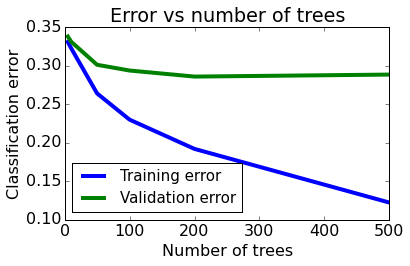

In [94]:
plt.plot([5, 10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([5, 10, 50, 100, 200, 500], valid_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,6), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

## Quiz question: Does the training error reduce as the number of trees increases?



In [95]:
#Yes

## Quiz question: Is it always true that the validation error will reduce as the number of trees increases?



In [96]:
#No